In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import os

print(tf.__version__)
print(keras.__version__)

2.0.0
2.2.4-tf


## 1. Set hyper parameters

In [2]:
learning_rate = 0.001
training_epochs = 15
batch_size = 100

tf.random.set_seed(777)

#### Create checkpoint directory

In [3]:
cur_dir = os.getcwd()
ckpt_dir_name = 'checkpoints'
model_dir_name = 'mnist_cnn_seq'

checkpoint_dir = os.path.join(cur_dir, ckpt_dir_name, model_dir_name)
os.makedirs(checkpoint_dir, exist_ok=True)

## 2. Make a data pipelining

In [4]:
mnist = keras.datasets.mnist
class_names = [str(i) for i in range(10)]
class_names

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

X shape : (28, 28)


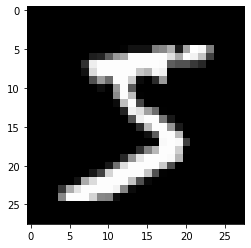

y label : 5


In [5]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print(f'X shape : {X_train[0].shape}')
plt.imshow(X_train[0].reshape(28,28), cmap='gray')
plt.show()
print(f'y label : {y_train[0]}')

X shape : (28, 28, 1)


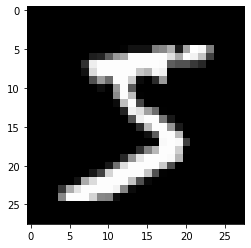

y label : [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [6]:
X_train = X_train.astype(np.float32)/255.
X_test = X_test.astype(np.float32)/255.

X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

y_train = to_categorical(y_train, 10)  # One-hot Encoding
y_test = to_categorical(y_test, 10)  # One-hot Encoding

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(buffer_size = 100000).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)


print(f'X shape : {X_train[0].shape}')
plt.imshow(X_train[0].reshape(28,28), cmap='gray')
plt.show()
print(f'y label : {y_train[0]}')

## 3. Build a neural network model - Sequential API

In [7]:
def create_model():
    model = keras.Sequential()
    
    model.add(keras.layers.Conv2D( filters=32, kernel_size=3, 
                                   activation=tf.nn.relu,
                                   padding='same',
                                   input_shape=(28,28,1) ))
    model.add(keras.layers.MaxPool2D( padding='same' ))
    model.add(keras.layers.Conv2D( filters=64, kernel_size=3, 
                                   activation=tf.nn.relu, 
                                   padding='same' ))
    model.add(keras.layers.MaxPool2D( padding='same' ))
    model.add(keras.layers.Conv2D( filters=128, kernel_size=3, 
                                   activation=tf.nn.relu,
                                   padding='same' ))
    model.add(keras.layers.MaxPool2D( padding='same' ))
    
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(256, activation=tf.nn.relu))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.Dense(10))
    return model

model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0

## 4. Define a Loss Function

In [8]:
@tf.function
def loss_fn(model, images, labels):
    logits = model(images, training=True)
    loss = tf.reduce_mean(
                tf.keras.losses.categorical_crossentropy(
                    y_pred=logits, y_true=labels, from_logits=True))
    return loss

## 5.Calculate a Gradient

In [9]:
@tf.function
def grad(model, images, labels):
    with tf.GradientTape() as tape:
        loss = loss_fn( model, images, labels )
    return tape.gradient(loss, model.variables)

## 6. Select an Optimizer

In [10]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

## 7. Define a Metric for model's performance

In [11]:
@tf.function
def evaluate(model, images, labels):
    logits = model(images, training=False)
    correct_prediction = tf.equal(tf.argmax(logits, 1),
                                  tf.argmax(labels, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return accuracy

## 8. Make a Checkpoint for saving

In [12]:
checkpoint = tf.train.Checkpoint(cnn = model)

## 9. Train and Validate a neural network model

In [13]:
@tf.function
def train(model, images, labels):
    grads = grad(model, images, labels)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))


print('Learning started. It takes sometime.')
for epoch in range(training_epochs):
    avg_loss = 0.
    avg_train_acc = 0.
    avg_test_acc = 0.
    train_step = 0
    test_step = 0
    
    for images, labels in train_dataset:
        train(model, images, labels)
        loss = loss_fn(model, images, labels)
        acc = evaluate(model, images, labels)
        
        avg_loss = avg_loss + loss
        avg_train_acc = avg_train_acc + acc
        train_step += 1
    
    avg_loss = avg_loss / train_step
    avg_train_acc = avg_train_acc / train_step
    
    for images, labels in test_dataset:
        acc = evaluate(model, images, labels)
        
        avg_test_acc = avg_test_acc + acc
        test_step += 1
    
    avg_test_acc = avg_test_acc / test_step
    
    print(f'Epoch : {epoch + 1}  |  loss = {avg_loss:.8f}  |  ' +
          f'train accuracy = {avg_train_acc:.4f}  |  '+
          f'test accuracy = {avg_test_acc:.4f}')
    checkpoint.save(file_prefix=checkpoint_dir)
    
print('Learning Finished !')

Learning started. It takes sometime.
Epoch : 1  |  loss = 0.16493475  |  train accuracy = 0.9580  |  test accuracy = 0.9851
Epoch : 2  |  loss = 0.04003141  |  train accuracy = 0.9902  |  test accuracy = 0.9904
Epoch : 3  |  loss = 0.02631592  |  train accuracy = 0.9935  |  test accuracy = 0.9931
Epoch : 4  |  loss = 0.01910933  |  train accuracy = 0.9953  |  test accuracy = 0.9919
Epoch : 5  |  loss = 0.01445978  |  train accuracy = 0.9965  |  test accuracy = 0.9921
Epoch : 6  |  loss = 0.01182489  |  train accuracy = 0.9975  |  test accuracy = 0.9933
Epoch : 7  |  loss = 0.00936022  |  train accuracy = 0.9980  |  test accuracy = 0.9918
Epoch : 8  |  loss = 0.00760872  |  train accuracy = 0.9984  |  test accuracy = 0.9924
Epoch : 9  |  loss = 0.00660610  |  train accuracy = 0.9987  |  test accuracy = 0.9894
Epoch : 10  |  loss = 0.00450421  |  train accuracy = 0.9991  |  test accuracy = 0.9916
Epoch : 11  |  loss = 0.00342321  |  train accuracy = 0.9993  |  test accuracy = 0.9929
Epoc